# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Jade Ducharme, Zacharias Escalante, Fei Fan, Soren Helhoski, Shi Yan*

This project aims to develop a machine learning model for classifying the redshifts of background
galaxies behind galaxy clusters using observational cosmology. By leveraging photometric proper-
ties of stars and galaxies, the project seeks to calculate new redshift values for each galaxy and
compare these with known spectroscopic redshift values to evaluate the model’s accuracy.

In [1]:
# import necessary packages
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Preprocessing

In [2]:
# Load data
from preprocess import load

data, labels, features = load("./data/specz_fluxes.csv", mode="mag")

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (12681, 6)
Label size [input_size,]:		 (12681,) 

Feature names: ['u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

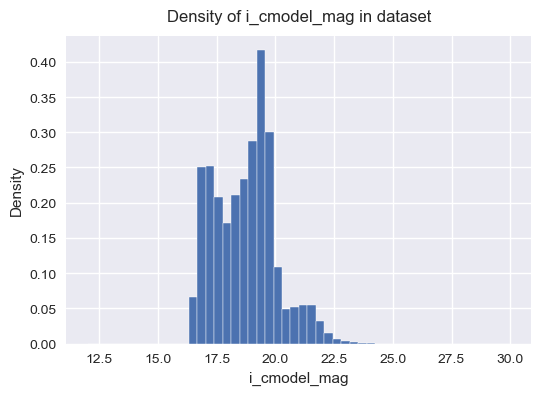

In [3]:
# Input visualization
from visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))

    

Next, we can also view how our labels align with any of the features in a 2D plot:

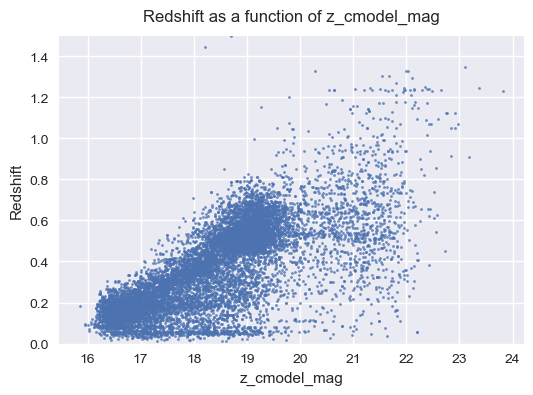

In [4]:
from visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="z_cmodel_mag", yrange=(0,1.5))

## Simple FCNN

As a first step, we would like to see how a simple FCNN performs.

In [5]:
from preprocess import preprocess_split
from model import SimpleFCNN, train_one_epoch, test

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=0.001)
acc_metric = torchmetrics.R2Score()  # TODO: maybe find a better accuracy metric?

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device,"\n")
simple_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=12, shuffle=True)
val_loader = DataLoader(val_set, batch_size=12, shuffle=True)
test_loader = DataLoader(test_set, batch_size=12, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(simple_fcnn, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(simple_fcnn, device, val_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Device: cpu 

Epoch 05	 Train loss: 0.0919	 Train acc: -3.1563	Val loss: 0.0965	 Val acc: -3.1053
Epoch 10	 Train loss: 0.0882	 Train acc: -2.7175	Val loss: 0.0918	 Val acc: -2.7057
Epoch 15	 Train loss: 0.0864	 Train acc: -2.6037	Val loss: 0.0888	 Val acc: -2.5935
Epoch 20	 Train loss: 0.0807	 Train acc: -2.5358	Val loss: 0.0829	 Val acc: -2.5354
Epoch 25	 Train loss: 0.0767	 Train acc: -2.5268	Val loss: 0.0817	 Val acc: -2.5231
Epoch 30	 Train loss: 0.0772	 Train acc: -2.5234	Val loss: 0.0803	 Val acc: -2.5190
Epoch 35	 Train loss: 0.0761	 Train acc: -2.5149	Val loss: 0.0841	 Val acc: -2.5172
Epoch 40	 Train loss: 0.0742	 Train acc: -2.5137	Val loss: 0.0762	 Val acc: -2.5125
Epoch 45	 Train loss: 0.0729	 Train acc: -2.5155	Val loss: 0.0838	 Val acc: -2.5117
Epoch 50	 Train loss: 0.0709	 Train acc: -2.5151	Val loss: 0.0749	 Val acc: -2.5135


In [6]:
# How does the model perform on unseen data?

test_loss, test_acc = test(simple_fcnn, device, test_loader, criterion, acc_metric)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.0598	 Final test acc: -2.5141


Next, we would like to visualize how our training went!

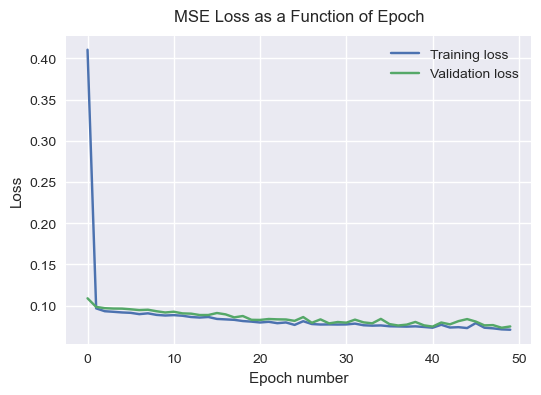

In [7]:
from visualize import plot_loss, plot_accuracy

plot_loss(loss_list, val_loss_list)

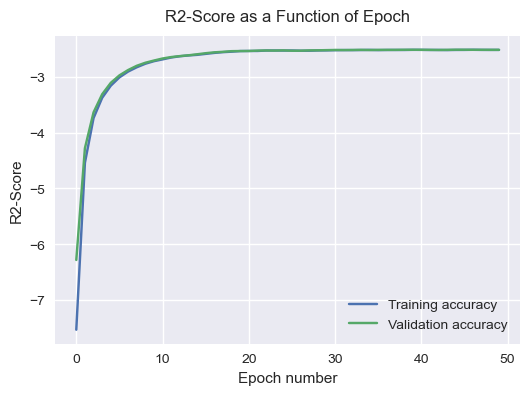

In [8]:
plot_accuracy(acc_list, val_acc_list)

Next, we would like to visualize the results of the model. In other words, given our set of test inputs, what kinds of outputs does our model predict?

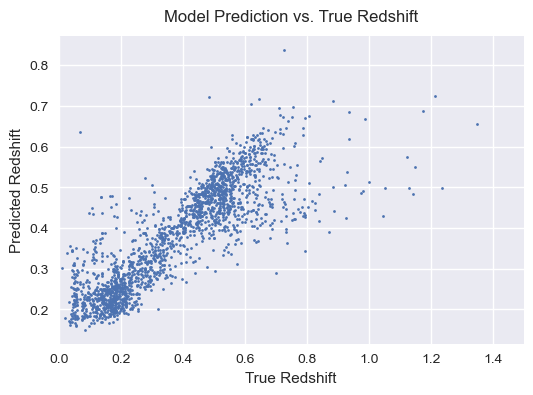

In [9]:
from visualize import visualize_predictions

visualize_predictions(test_set, simple_fcnn, xrange=(0,1.5))

## 1D CNN

In [10]:
#TODO!